## Оглавление<a id="heading"></a>
1. [Описание проекта](#1)
2. [Условные обозначения](#2)
3. [Открытие файла и ознакомление с данными](#3)
4. [Предобработка данных](#4)
5. [Кодирование](#5)
6. [Работа с моделями](#6)
  - [Разбитие на выборки, выделение признаков и цели](#6.1)
  - [Проверка моделей до баланса классов](#6.2)
  - [Проверка моделей после применения class_weight](#6.3)
  - [Подготовка данных для upsampling](#6.4)
  - [Проверка моделей после применения upsampling](#6.5)
  - [Подготовка данных для downsampling](#6.6)
  - [Проверка моделей после применения downsampling](#6.7)
  - [Повышение метрики F1 у лучшей модели](#6.8)
  - [Вывод](#6.9)

##  1. Описание проекта<a id="1"></a>


Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

## 2. Условные обозначения<a id='2'>
[Открытие файла и ознакомление с данными▼](#3) [Оглавление▲▲](#heading)

Признаки





RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — количество недвижимости у клиента

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата






Целевой признак

Exited — факт ухода клиента

## 3. Открытие файла и ознакомление с данными<a id='3'>
[Предобработка данных▼](#4) [Оглавление▲▲](#heading)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

try:
    df=pd.read_csv('/datasets/Churn.csv')
except:
    df=pd.read_csv('C:/Users/ASUS/Desktop/практикум/модуль 2/спринт 2. Обучение с учителем/churn.csv')
display(df.head())
print(df.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


Процентное соотношение классов в целевом признаке: 0    0.7963
1    0.2037
Name: Exited, dtype: float64


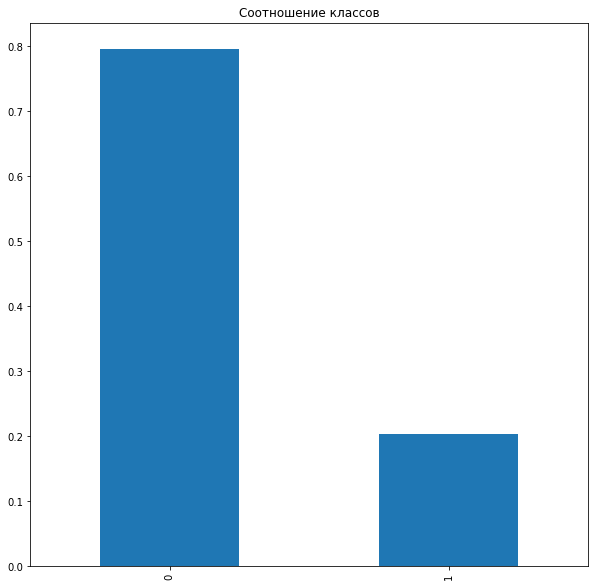

In [2]:
# подсчитываем и визуализируем соотношение классов в целевом признаке
(print('Процентное соотношение классов в целевом признаке:', 
      df['Exited'].value_counts(normalize=True)))

df['Exited'].value_counts(normalize=True).plot(kind='bar', 
                        figsize=(10, 10), title='Соотношение классов')
plt.show()

### В результате первичного ознакомления с данными выяснилось, что в одном столбце имеются пропуски. Между классами в целевом признаке существует значительный дисбаланс (1:4) в пользу отрицательного класса. Несколько столбцов не имеют никакого влияния на целевой признак и могут быть безболезненно удалены. 

## 4. Предобработка данных<a id='4'>
[Кодирование▼](#5) [Оглавление▲▲](#heading)

In [3]:
# приводим названия столбцов к нижнему регистру
df.columns=df.columns.str.lower()



# подсчитываем уникальные значения в столбцах
print('Уникальные значения в столбце "наличие кредитной карты":', 
      df['hascrcard'].unique())
print('\n\n')

print('Уникальные значения в столбце "активность клиента":' 
      ,df['isactivemember'].unique())
print('\n\n')

print('Уникальные значения в столбце "страна":' 
      ,df['geography'].unique())
print('\n\n')

print('Уникальные значения в столбце "пол":' 
      ,df['gender'].unique())
print('\n\n')



# подсчитываем кол-во пропусков
print("Процент пропусков в столбце 'недвижимость':",
      df['tenure'].isna().sum()/len(df)*100)

# пропусков менее 10%. заменим их на медиану по столбцу
df['tenure']=df['tenure'].fillna(df['tenure'].median())
print('\n\n')



# удаляем столбцы, не несущие никакой смысловой нагрузки
df=df.drop(['rownumber', 'customerid', 'surname'], axis=1)

Уникальные значения в столбце "наличие кредитной карты": [1 0]



Уникальные значения в столбце "активность клиента": [1 0]



Уникальные значения в столбце "страна": ['France' 'Spain' 'Germany']



Уникальные значения в столбце "пол": ['Female' 'Male']



Процент пропусков в столбце 'недвижимость': 9.09





## 5. Кодирование<a id='5'>
[Работа с моделями▼](#6) [Оглавление▲▲](#heading)

In [4]:
# проводим прямое кодирование данных в таблице
df=pd.get_dummies(df, drop_first=True)
display(df.head())


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


## 6. Работа с моделями<a id='6'>
[6.1 Разбитие на выборки, выделение признаков и цели▼](#6.1) [Оглавление▲▲](#heading)

### Для начала разобьем наши данные на 3 выборки: обучающую, валидационную и тестовую. Затем будем искать модель с наилучшим показателем метрики. В качестве метрик будем использовать F1  и AUC-ROC. Однако, т.к. метрика F1 очень чувствительна к изменению порога классификации, то для грубой оценки моделей будем использовать метрику AUC-ROC, а после выявления наилучшей модели в результате балансировки классов вернемся к метрике F1 для тонкой настройки полученной модели.

## 6.1. Разбитие на выборки, выделение признаков и цели<a id='6.1'>
[Проверка моделей до баланса классов▼](#6.2) [Оглавление▲▲](#heading)

In [5]:
# разбиваем датасет сначала на обучающий и промежуточный, затем промежуточный 
# на тестовый и валидационный
df_train, df_1=(train_test_split
(df, random_state=1, test_size=0.40, shuffle=True, stratify=df['exited']))

df_test, df_valid=(train_test_split
(df_1, random_state=1, test_size=0.50, shuffle=True, stratify=df_1['exited']))


# проверяем размерности полученных датасетов
print('валидационная выборка:', df_valid.shape)
print('тестовая выборка:',df_test.shape)
print('обучающая выборка:',df_train.shape)


# создаем признаки и цели для каждой из выборок
features_train=df_train.drop(['exited'], axis=1)
target_train=df_train['exited']

features_valid=df_valid.drop(['exited'], axis=1)
target_valid=df_valid['exited']

features_test=df_test.drop(['exited'], axis=1)
target_test=df_test['exited']

валидационная выборка: (2000, 12)
тестовая выборка: (2000, 12)
обучающая выборка: (6000, 12)


In [6]:
# сохраняем обучающую и валидационную выборки в отдельные переменные для
# логистической регрессии
features_train_scaled=features_train
features_valid_scaled=features_valid
features_test_scaled=features_test

# сохраняем в переменную численные признаки
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

# стандартизируем признаки
scaler = StandardScaler()
scaler.fit(features_train_scaled[numeric])
features_train_scaled[numeric] = scaler.transform(features_train_scaled[numeric])
features_valid_scaled[numeric] = scaler.transform(features_valid_scaled[numeric])
features_test_scaled[numeric] = scaler.transform(features_test_scaled[numeric])

## 6.2. Проверка моделей до баланса классов<a id='6.2'>
[Проверка моделей после применения class_weight▼](#6.3) [Оглавление▲▲](#heading)

In [7]:
# исследуем модель логистической регрессии до баланса классов
model=LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_train_scaled, target_train)
predicted_valid_scaled = model.predict(features_valid_scaled)

probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(target_valid, predicted_valid_scaled)

print('auc-roc логистической регрессии', auc_roc)
print('f1 логистической регрессии:', f1)
print('\n\n')




# исследуем модель дерева до баланса классов
tree = DecisionTreeClassifier(random_state=1)
tree.fit(features_train, target_train)
predictions_valid = tree.predict(features_valid)


probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc дерева', auc_roc)
print('F1:', f1)
print('\n\n')





# исследуем модель случайного леса до баланса классов   
forest=RandomForestClassifier(random_state=1)
forest.fit(features_train, target_train)
predictions_valid=forest.predict(features_valid)
    
        
probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc случайного леса', auc_roc)
print('F1', f1)  

auc-roc логистической регрессии 0.7587785742437678
f1 логистической регрессии: 0.26436781609195403



auc-roc дерева 0.6743090452261307
F1: 0.4783118405627198



auc-roc случайного леса 0.8426730773967878
F1 0.5628930817610063


### Вывод: лучше всего себя показала модель случайного леса, причем по обоим метрикам. Далее проверим модели после отработки дисбаланса.

## 6.3. Проверка моделей после применения class_weight<a id='6.3'>
[Подготовка данных для upsampling▼](#6.4) [Оглавление▲▲](#heading)

In [8]:
# проверяем модель с балансом классов в аргументах модели
model=LogisticRegression(class_weight='balanced', random_state=1, solver='liblinear')
model.fit(features_train_scaled, target_train)
predicted_valid_scaled = model.predict(features_valid_scaled)

probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predicted_valid_scaled, target_valid)

print('auc-roc логистической регрессии', auc_roc)
print('f1 логистической регрессии:', f1)
print('\n\n')



# исследуем модель дерева
tree = DecisionTreeClassifier(class_weight='balanced', random_state=1)
tree.fit(features_train, target_train)
predictions_valid = tree.predict(features_valid)
    
probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc дерева', auc_roc)
print('F1:', f1)
print('\n\n') 
    
    
    
    
# исследуем модель случайного леса    
forest=RandomForestClassifier(class_weight='balanced', random_state=1)
forest.fit(features_train, target_train)
predictions_valid=forest.predict(features_valid)
    
probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc', auc_roc)
print('F1:', f1)  

auc-roc логистической регрессии 0.7615174524583703
f1 логистической регрессии: 0.49684968496849685



auc-roc дерева 0.689476795743423
F1: 0.5088607594936709



auc-roc 0.8427616021282885
F1: 0.5529225908372828


### Вывод: модель случайного леса опять показала лучшие результаты сразу по обоим метрикам.

## 6.4. Подготовка данных для upsampling<a id='6.4'>
[Проверка моделей после применения upsampling▼](#6.5) [Оглавление▲▲](#heading)

In [9]:
# увеличиваем объекты класса "1" и сохраняем преобразованные выборки в новых
# переменных
def upsample(features_scaled, target, features, repeat):
    features_scaled_zeros = features_train_scaled[target_train == 0]
    features_scaled_ones = features_train_scaled[target_train == 1]
    
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    display(features_scaled_zeros.shape, features_scaled_ones.shape,
        target_zeros.shape, target_ones.shape,
        features_zeros.shape, features_ones.shape)

    features_upsampled_scaled = pd.concat([features_scaled_zeros] + 
                                   [features_scaled_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * 
                                                                  repeat)
    
     
    features_upsampled_scaled, target_upsampled, features_upsampled = (shuffle
    (features_upsampled_scaled, target_upsampled, 
     features_upsampled, random_state = 1))

    return features_upsampled_scaled, target_upsampled, features_upsampled


features_upsampled_scaled, target_upsampled, features_upsampled = (upsample
(features_train_scaled, target_train, features_train, 4))

(4778, 11)

(1222, 11)

(4778,)

(1222,)

(4778, 11)

(1222, 11)

## 6.5. Проверка моделей после применения upsampling<a id='6.5'>
[Подготовка данных для downsampling▼](#6.6) [Оглавление▲▲](#heading)

In [10]:
# проверяем модель после применения техники upsampling 
model=LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_upsampled_scaled, target_upsampled)
predicted_valid_scaled = model.predict(features_valid_scaled)

probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predicted_valid_scaled, target_valid)

print('auc-roc логистической регрессии', auc_roc)
print('f1 логистической регрессии:', f1)
print('\n\n')





# исследуем модель дерева
tree = DecisionTreeClassifier(random_state=1)
tree.fit(features_upsampled, target_upsampled)
predictions_valid = tree.predict(features_valid)
    
        
probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc дерева', auc_roc)
print('F1:', f1)
print('\n\n') 
    
    
    
    
    
# исследуем модель случайного леса    
forest=RandomForestClassifier(random_state=1)
forest.fit(features_upsampled, target_upsampled)
predictions_valid=forest.predict(features_valid)


probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc', auc_roc)
print('F1:', f1)  

auc-roc логистической регрессии 0.7615343876243965
f1 логистической регрессии: 0.49552772808586765



auc-roc дерева 0.6847965316779978
F1: 0.5



auc-roc 0.837696447925904
F1: 0.5710306406685237


### Вывод: ничего не меняется, модель случайного леса опять лучше других.

## 6.6.  Подготовка данных для downsampling<a id='6.6'>
[Проверка моделей после применения downsampling▼](#6.7) [Оглавление▲▲](#heading)

In [11]:
# уменьшаем объекты класса "0" и сохраняем преобразованные выборки в новых
# переменных
def downsample(features_scaled, features, target, fraction):
    features_scaled_zeros = features_train_scaled[target_train == 0]
    features_scaled_ones = features_train_scaled[target_train == 1]
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled_scaled = pd.concat(
        [features_scaled_zeros.sample(frac=fraction, random_state=1)] + 
        [features_scaled_ones])
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1)] + 
        [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1)] + 
        [target_ones])
    features_downsampled_scaled, features_downsampled, target_downsampled = shuffle(features_downsampled_scaled, features_downsampled, target_downsampled, random_state=1)
    
    return features_downsampled_scaled, features_downsampled, target_downsampled

features_downsampled_scaled, features_downsampled, target_downsampled = downsample(
    features_train_scaled, features_train, target_train, 0.25)


# проверяем объем полученных выборок
print(features_downsampled_scaled.shape, features_downsampled.shape, target_downsampled.shape)

(2416, 11) (2416, 11) (2416,)


## 6.7. Проверка моделей после применения downsampling<a id='6.7'>
[Повышение метрики F1 у лучшей модели сдвигом порога классификации▼](#6.8) [Оглавление▲▲](#heading)

In [12]:
# проверяем модель после применения техники downsampling 
model=LogisticRegression(random_state=1, solver='liblinear')
model.fit(features_downsampled_scaled, target_downsampled)
predicted_valid_scaled = model.predict(features_valid_scaled)

probabilities_valid = model.predict_proba(features_valid_scaled)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predicted_valid_scaled, target_valid)

print('auc-roc логистической регрессии', auc_roc)
print('f1 логистической регрессии:', f1)
print('\n\n')





# исследуем модель дерева
tree = DecisionTreeClassifier(random_state=1)
tree.fit(features_downsampled, target_downsampled)
predictions_valid = tree.predict(features_valid)

        
probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)

print('auc-roc дерева', auc_roc)
print('F1:', f1)
print('\n\n') 
    
    
    
    
# исследуем модель случайного леса    
forest=RandomForestClassifier(random_state=1)
forest.fit(features_downsampled, target_downsampled)
predictions_valid=forest.predict(features_valid)


probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc=roc_auc_score(target_valid, probabilities_one_valid)
f1=f1_score(predictions_valid, target_valid)


print('auc-roc', auc_roc)
print('F1:', f1)  

auc-roc логистической регрессии 0.7609863040693665
f1 логистической регрессии: 0.4923354373309287



auc-roc дерева 0.7085611882944132
F1: 0.49956178790534617



auc-roc 0.836269275298059
F1: 0.5580057526366251


### После всех примененных методов борьбы с дисбалансом лучше других по 2 метрикам показала себя модель случайного леса. В целом, у моделей не сильно отличались метрики от метода к методу. На следующем этапе попробуем поднять метрику F1 у случайного леса подбором гиперпараметров и сдвигом порога классификации.

## 6.8. Повышение метрики F1 у лучшей модели <a id='6.8'>
[Вывод▼](#6.9) [Оглавление▲▲](#heading)

11 0.5673352435530086
21 0.605



Порог = 0.46 | f1 = 0.62 | Precision = 0.58 | Recall = 0.66





,importance
age,0.308383
numofproducts,0.190969
balance,0.129303
estimatedsalary,0.099722
creditscore,0.087915
tenure,0.054680
isactivemember,0.043935
geography_Germany,0.038252
gender_Male,0.023947
hascrcard,0.012599


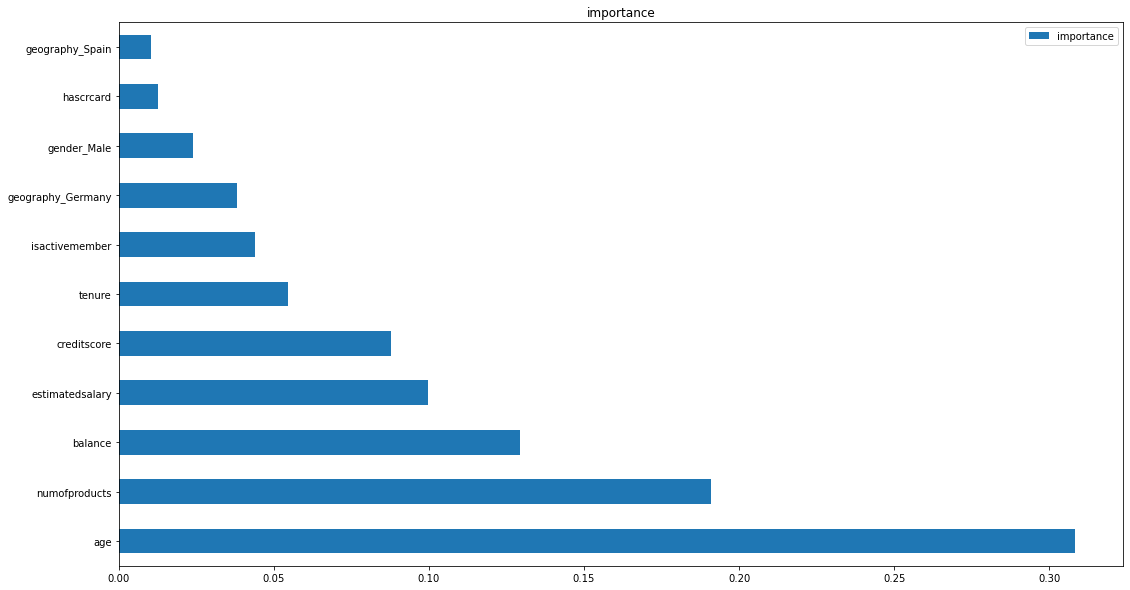

In [13]:
# объединяем обучающую и валидационную выборки
features_final=pd.concat([features_train] + [features_valid])
target_final=pd.concat([target_train] + [target_valid])


# подбираем оптимальную глубину леса при небольшом кол-ве деревьев
n=0
f1=0

for depth in range(1, 16, 1):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=20, max_depth=depth, random_state=1)
    model.fit(features_final, target_final)
    predictions_test = model.predict(features_test)
    result=f1_score(predictions_test, target_test)
    
    if result>f1:
        n=depth
        f1=result
print(n, result)




# подбираем оптимальное кол-во деревьев в лесу
estimators=0
f1=0

for i in range(1, 150, 10):
    model = RandomForestClassifier(class_weight='balanced', n_estimators=i, max_depth=n, random_state=1)
    model.fit(features_final, target_final)
    predictions_test = model.predict(features_test)
    result=f1_score(predictions_test, target_test)
    if result>f1:
        estimators=i
        f1=result
print(estimators, result)


# улучшаем модель сдвигом порога классификации
forest = RandomForestClassifier(class_weight='balanced', n_estimators=21, max_depth=11, random_state=1)
forest.fit(features_final, target_final)
probabilities_test = forest.predict_proba(features_test)
probabilities_one_valid = probabilities_test[:, 1]

f1_forest=0
count=0
prec=0
rec=0

for threshold in np.arange(0, 0.7, 0.01):
    predicted_test = probabilities_one_valid > threshold
    result_forest=f1_score(predicted_test, target_test)
    precision = precision_score(target_test, predicted_test)
    recall = recall_score(target_test, predicted_test)
    
    if result_forest>f1_forest:
        f1_forest=result_forest
        count=threshold
        prec=precision
        rec=recall
        
print('\n\n')
print("Порог = {} | f1 = {:.2f} | Precision = {:.2f} | Recall = {:.2f}".format(count, f1_forest, prec, rec))
print('\n\n')



feature_importances=(pd.DataFrame(forest.feature_importances_,
                    index=features_final.columns, columns=["importance"])
                     .sort_values(by='importance', ascending=False))
display(feature_importances)
feature_importances.plot(kind='barh', figsize=(18, 10))
plt.title('importance')
plt.show()

## 6.9. Вывод <a id='6.9'>
[Оглавление▲▲](#heading)

### В результате проделанных преобразований выяснилось, что самая лучшая модель - случайный лес. Эта модель при использовании разных методов устранения дисбаланса стабильно показывала самые высокие показатели метрик по сравнению с другими моделями. Путем устранения дисбаланса классов, подбора гиперпараметров и сдвигом порога классификации удалось незначительно поднять метрику F1 (до 0,62) против изначальных 0,56 (при дисбалансе классов). При этом доля угаданных классов "1" среди всех предсказанных классов "1" составляет 68%, тогда как доля угаданных классов "1" среди всех истинных классов "1" составила 58%. Наибольшую значимость для целевой переменной играют возраст, кол-во продуктов банка, используемых клиентом, и баланс счета.